# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

## imports

In [169]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import geopandas
import statsmodels.api as sm
from scipy.stats import binom
import matplotlib.cm as cm

# print(os.getcwd())


## 1-2 Create DataFrame and save it as csv file

In [130]:
def get_data():   
    data = pd.read_csv("nowdatabase.txt", sep=',', encoding='latin-1', dtype=str)
    data.to_csv('data.csv', index=False)
    data.dropna(subset=['LAT', 'LONG', 'MAX_AGE', 'MIN_AGE'], how='all', inplace=True)

    return data

def get_rows():
    data = get_data()
    num_rows = data.shape[0]
    return num_rows


if __name__ == '__main__':
    number = get_rows()
    print(f"The dataframe contains {number} rows.")

The dataframe contains 83225 rows.


### Idea of solution
1. read txt file with specific parameters
2. convert to csv file using to_csv()
3. get the number of rows

### Discussion
1. in this ipynb file the file path is not needed, only provide the txt file name
2. add encoding parameter when reading the txt file to deal with UnicodeDecodeError
3. using dtype=str to avoid DtypeWarning

## 3 Cleaning and processing steps
1. Remove all rows where LAT = LONG = 0; these occurrences have incorrect coordinates. \
Drop rows where SPECIES is “sp.” or “indet.”; these occurrences have not been properly identified.
2. Assign occurrence to specific MN time unit
3. Correct time unit for "Samos main bone beds", "Can Llobateres I" to MN12 and MN9
4. Create new column and label each occurences with identification number
5. Remove duplicate copies in each locality
6. Get number of rows left, get number of unique species and locality identified

In [147]:
def assign_to_MN(mean):
    name = pd.NA
    mean_rounded = round(mean, 2)
    boundary_dict = {
        "MN1": {"name": "MN1", "age_max": 23, "age_min": 21.7},
        "MN2": {"name": "MN2", "age_max": 21.7, "age_min": 19.5},
        "MN3": {"name": "MN3", "age_max": 19.5, "age_min": 17.2},
        "MN4": {"name": "MN4", "age_max": 17.2, "age_min": 16.4},
        "MN5": {"name": "MN5", "age_max": 16.4, "age_min": 14.2},
        "MN6": {"name": "MN6", "age_max": 14.2, "age_min": 12.85},
        "MN7-8": {"name": "MN7-8", "age_max": 12.85, "age_min": 11.2},
        "MN9": {"name": "MN9", "age_max": 11.2, "age_min": 9.9},
        "MN10": {"name": "MN10", "age_max": 9.9, "age_min": 8.9},
        "MN11": {"name": "MN11", "age_max": 8.9, "age_min": 7.6},
        "MN12": {"name": "MN12", "age_max": 7.6, "age_min": 7.1},
        "MN13": {"name": "MN13", "age_max": 7.1, "age_min": 5.3},
        "MN14": {"name": "MN14", "age_max": 5.3, "age_min": 5},
        "MN15": {"name": "MN15", "age_max": 5, "age_min": 3.55},
        "MN16": {"name": "MN16", "age_max": 3.55, "age_min": 2.5},
        "MN17": {"name": "MN17", "age_max": 2.5, "age_min": 1.9},
        "MQ18": {"name": "MQ18", "age_max": 1.9, "age_min": 0.85},
        "MQ19": {"name": "MQ19", "age_max": 0.85, "age_min": 0.01},
    }
    # Check for pre-MN and post-MN cases
    if mean_rounded >= boundary_dict["MN1"]["age_max"]:
        return "pre-MN"
    elif mean_rounded < boundary_dict["MQ19"]["age_min"]:
        return "post-MN"


    # Check for each MN boundary
    for key, value in boundary_dict.items():
        if value["age_min"] < mean_rounded < value["age_max"]:
            name = value["name"]
            break
        # Handle mean age precisely on the boundary
        elif mean_rounded == value["age_min"]:
            name = value["name"]
            break

    return name

# main function
def clean_and_process():
    data = get_data()

    # 1 remove incorrect data
    data = data[(data.LAT != 0) & (data.LONG != 0)]
    data = data[(data.SPECIES != "sp.") & (data.SPECIES != "indet.")]
    
    # 2 Assign to MN time unit
    data['MAX_AGE'] = pd.to_numeric(data['MAX_AGE'], errors='coerce')
    data['MIN_AGE'] = pd.to_numeric(data['MIN_AGE'], errors='coerce')
    age_mean_col = ['MAX_AGE', 'MIN_AGE']
    data['MN'] = data[age_mean_col].mean(axis=1, skipna=True).apply(assign_to_MN)

    #3 Correct MN for 2 localities
    data.loc[data['NAME'] == 'Samos Main Bone Beds', 'MN'] = 'MN12'
    data.loc[data['NAME'] == 'Can Llobateres 1', 'MN'] = 'MN9'

    #4 identification for unique genus-species combination
    data["GENUS_SPECIES"] = data["GENUS"] + "_" + data["SPECIES"]
    code, _ = pd.factorize(data["GENUS_SPECIES"])
    data["SPECIES_ID"] = code

    #5 remove duplicate copies for each locality
    data = data[~data.groupby("NAME")["SPECIES_ID"].transform(lambda x: x.duplicated())]
    numeric_LIDNUM = data['LIDNUM'].str.isdigit()
    data = data[numeric_LIDNUM]

    # check: Calculate the mean and get MN for the selected row
    # num = 35
    # specific_row = data.iloc[num]
    # mean_for_specific_row = specific_row[['MAX_AGE', 'MIN_AGE']].mean()
    # print(f"check - MN for the row{num}:")
    # print(assign_to_MN(mean_for_specific_row))
    # print(data.iloc[num]["NAME"])
    # print(data.loc[data["NAME"] == 'Can Llobateres 1', "SPECIES_ID"])

    return data

if __name__ == '__main__':
    data = clean_and_process()
    #6 rows left
    print(f"The dataframe left {data.shape[0]} rows.")
    # check for 2
    # print(data['MN'][0:20])
    # check for update 3
    # index_samos = data[data['NAME'] == 'Can Llobateres 1'].index[0]
    # print(data.loc[index_samos, "MN"])
    # check species id 4
    # print(data.iloc[5000])

The dataframe left 61444 rows.


### Idea of solution
1. clean incorrect rows
2. calculate the mean of MAX_AGE and MIN_AGE, assign the time unit according to the boundary dict
3. iloc find the specific localities namea and update its NM value
4. create a combination column and use pd.factorize()to get unique number according to the combination
5. group id by each locality, implicate duplicated(), ~remove all copies

### Discussion
1. (p2)beside the incorrect value, there is also non numeric value have to be converted to NAN, \
 and skip it when caluculate the mean(skipna=True), set it's time unit to pd.NA too. Note that MN1 is the oldest time, \
 if mean equal to the min it means it also equal to next's max so it should be set to the min's name
2. (p5)Apply() operates on the entire DataFrame while Transform() operates on a subset; \
duplicated is not function of transform, use lambda to implcate it.

## 4 Occurrences
1. Two Dataframe: occurrences per time unit, time unit of first observed
2. first and all proportion in each time unit, plot the change through time

In [ ]:
def create_df():
    

                  GENUS_SPECIES First_Observed_MN  SPECIES_ID LIDNUM
0              Aaptoryctes_ivyi            pre-MN        3648  10168
1        Abderites_meridionalis               MN4         678  28891
2             Abdounodus_hamdii            pre-MN        6680  22640
3        Abelmoschomys_phthanus               MN9        3294  10465
4        Abelmoschomys_simpsoni              MN10        6774  10567
...                         ...               ...         ...    ...
11237  Zygolophodon_shansiensis              MN12       11209  24925
11238   Zygolophodon_turicensis               MN3         343  21188
11239        Zygomaturus_keanei              MN15        9431  27667
11240            gen._dicranius              MN16        7716  20470
11241            indet._indet..            pre-MN        8276  27695

[11242 rows x 4 columns]


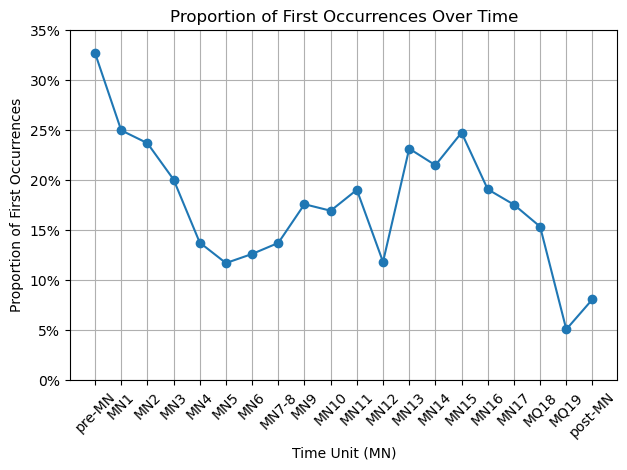

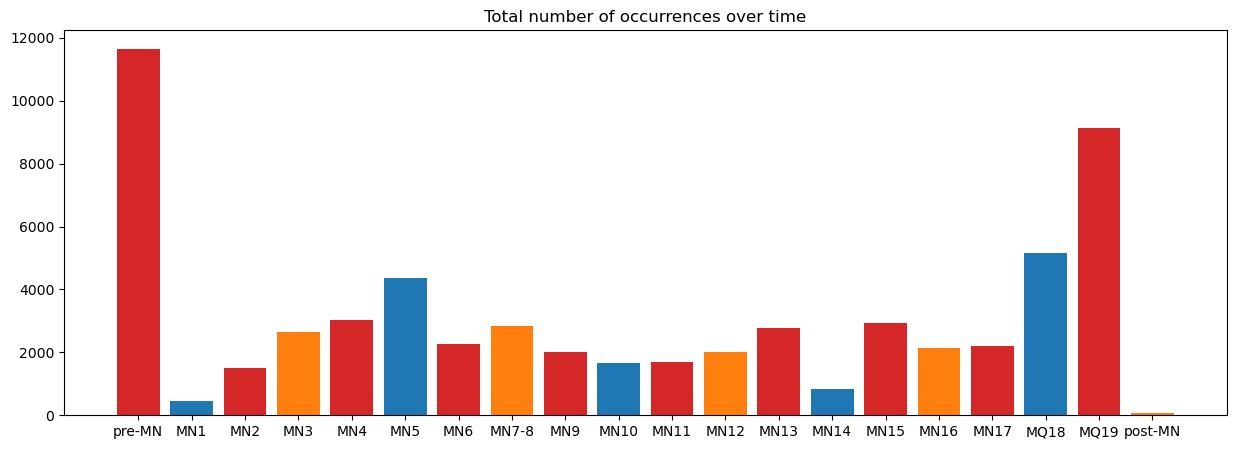

In [148]:
mn_order = ['pre-MN', 'MN1', 'MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19', 'post-MN']

# get dataframe1
def occurrences_per_time():
    data = clean_and_process()
    occ_per_time = data['MN'].value_counts()
    occ_per_time_df = occ_per_time.reset_index()
    occ_per_time_df.columns = ['MN', 'OCC_Count']
    # correct order
    occ_per_time_df['MN'] = pd.Categorical(occ_per_time_df['MN'], categories=mn_order, ordered=True)
    occ_per_time_df = occ_per_time_df.sort_values(by='MN')
    occ_per_time_df = occ_per_time_df.reset_index(drop=True)
    return occ_per_time_df
# get dataframe 2
def first_observed():
    data = clean_and_process()
    first_observed_dict = {}
    for species, group in data.groupby('GENUS_SPECIES'):
        first_mn = min(group['MN'], key=lambda x: mn_order.index(x) if isinstance(x, str) and x in mn_order else np.inf)
        first_observed_dict[species] = first_mn

    first_observed_df = pd.DataFrame(list(first_observed_dict.items()), columns=['GENUS_SPECIES', 'First_Observed_MN'])
    # add unique id to the df
    first_observed_df.set_index(data.groupby('GENUS_SPECIES')['SPECIES_ID'].first().index, inplace=True)    
    first_observed_df['SPECIES_ID'] = data.groupby('GENUS_SPECIES')['SPECIES_ID'].first()
    first_observed_df['LIDNUM'] = data.groupby('GENUS_SPECIES')['LIDNUM'].first()
    first_observed_df.reset_index(drop=True, inplace=True)
    print(first_observed_df)
    return first_observed_df

# get proportion
def get_first_proportion():
    all_count = occurrences_per_time()
    first_count = first_observed()['First_Observed_MN'].value_counts()
    # correct order
    first_count = first_count.reindex(mn_order)
    first_count = first_count.reset_index()
    first_count.columns = ['MN', 'Count']
    first_proportion = first_count['Count'] / all_count['OCC_Count']
    proportion_df = pd.DataFrame({'MN': first_count['MN'], 'Proportion': first_proportion})

    # print(all_count)
    # print(first_count)
    # print(proportion_df)
    return proportion_df

if __name__ == '__main__':
    # print(occurrences_per_time())
    # print(fisrt_observed())

    # plot propotion1
    proportion_df = get_first_proportion()
    # plt.figure(figsize=(10, 6))
    plt.plot(proportion_df['MN'], proportion_df['Proportion'], marker='o', linestyle='-')
    plt.xlabel('Time Unit (MN)')
    plt.ylabel('Proportion of First Occurrences')
    plt.title('Proportion of First Occurrences Over Time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.gca().set_yticks(plt.gca().get_yticks())
    plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
    plt.tight_layout()
    plt.show()

    # plot total number
    total_df = occurrences_per_time()
    fig, ax = plt.subplots(figsize=(15, 5))
    bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
    ax.bar(total_df['MN'], total_df['OCC_Count'], color = bar_colors)
    ax.set_title('Total number of occurrences over time')
    plt.show()




### Idea of solution
1. calculates the number of occurrences of each time unit ('MN') , correct the MN order
2. group by species and get the min MN order(the oldest),create df set id to index for clearing
3. from previous 2 funtion get the all occurrences count and first time count, calculate the proportion

### Discussion
1. some species have NAN MN time unit, don't know if them should be drop
2. Series can use reindex to correct order
3. bar chart looks better when plot the total number over time

## 5 Groprapgic pattern
1. df about locality number (LIDNUM), longitude, latitude, time unit, number of first occurrences in the locality, \
number of all occurrences in the locality and proportion of first occurrences in the locality
2. Visualize the distribution of localities in space and time.

/var/folders/_r/cgkzrs6969g_s1zjnk1m6rl00000gn/T/ipykernel_55137/811364019.py:47: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


                  GENUS_SPECIES First_Observed_MN  SPECIES_ID LIDNUM
0              Aaptoryctes_ivyi            pre-MN        3648  10168
1        Abderites_meridionalis               MN4         678  28891
2             Abdounodus_hamdii            pre-MN        6680  22640
3        Abelmoschomys_phthanus               MN9        3294  10465
4        Abelmoschomys_simpsoni              MN10        6774  10567
...                         ...               ...         ...    ...
11237  Zygolophodon_shansiensis              MN12       11209  24925
11238   Zygolophodon_turicensis               MN3         343  21188
11239        Zygomaturus_keanei              MN15        9431  27667
11240            gen._dicranius              MN16        7716  20470
11241            indet._indet..            pre-MN        8276  27695

[11242 rows x 4 columns]


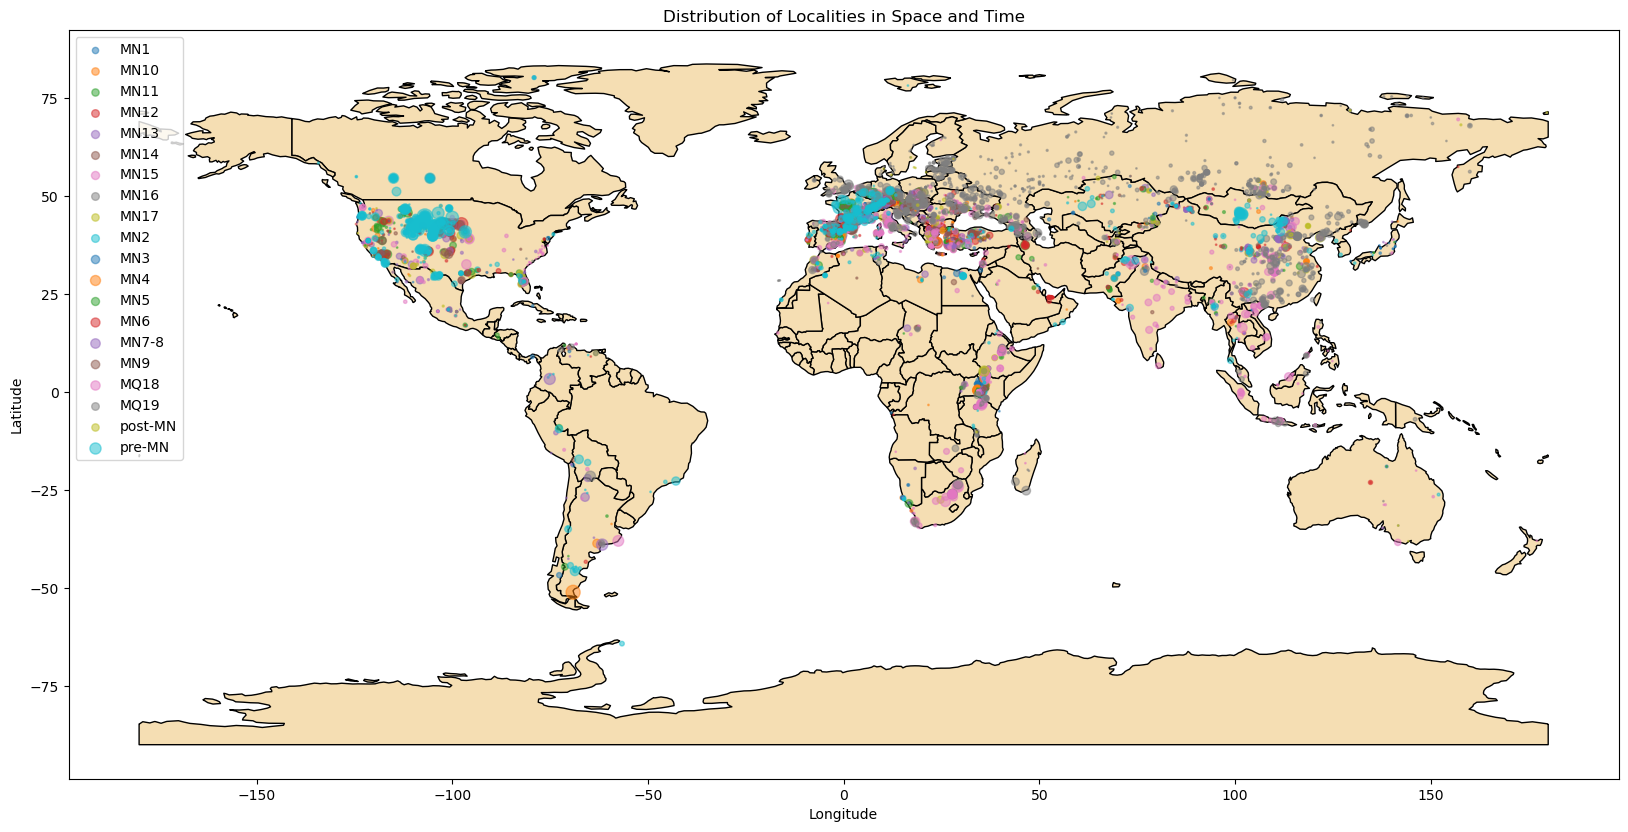

In [149]:
# get locality info df
def get_locality(data, first_observed_df):
    # Number of first occurrences in the locality
    locality_first_count = first_observed_df['LIDNUM'].value_counts().reset_index()
    locality_first_count.columns = ['LIDNUM', 'First_Occurrences']
    locality_first_count.fillna(0, inplace=True) 
    # Number of all occurrences in the locality
    locality_all_occ_count = data["LIDNUM"].value_counts().reset_index()
    locality_all_occ_count.columns = ['LIDNUM', 'All_Occurrences']
    locality_all_occ_count.fillna(0, inplace=True) 

    # Merge data with locality_first_count and locality_all_occ_count
    merged_data = data.merge(locality_first_count, on='LIDNUM', how='left')
    merged_data = merged_data.merge(locality_all_occ_count, on='LIDNUM', how='left')
    # drop duplicates
    merged_data = merged_data[['LIDNUM', 'LAT', 'LONG', 'MN', 'First_Occurrences', 'All_Occurrences']].drop_duplicates()
    # Calculate proportion of first occurrences
    merged_data['Proportion_First'] = merged_data['First_Occurrences'] / merged_data['All_Occurrences']
    merged_data['Proportion_First'].fillna(0, inplace=True)

    # Create a DataFrame to collect locality information
    locality_df = pd.DataFrame({
        'LIDNUM': merged_data['LIDNUM'],       # Unique locality numbers
        'Longitude': merged_data['LONG'],      # Longitude of the locality
        'Latitude': merged_data['LAT'],        # Latitude of the locality
        'Time_Unit': merged_data['MN'],        # Uncomment if necessary
        'First_Occurrences': merged_data['First_Occurrences'],
        'All_Occurrences': merged_data['All_Occurrences'],
        'Proportion_First': merged_data['Proportion_First']
    })

    locality_df.loc[:, ["First_Occurrences", "All_Occurrences", "Proportion_First"]] = locality_df[["First_Occurrences", "All_Occurrences", "Proportion_First"]].fillna(0)
    return locality_df

def clean_data(df):
    # Drop rows with NaN values in 'Longitude' or 'Latitude' columns
    df = df.dropna(subset=['Longitude', 'Latitude'])
    # Drop rows with invalid entries in the 'LIDNUM' column
    df = df[df['LIDNUM'].str.isdigit()]
    # Convert 'Longitude' and 'Latitude' columns to numeric types
    df['Longitude'] = pd.to_numeric(df['Longitude'])
    df['Latitude'] = pd.to_numeric(df['Latitude'])
    return df

if __name__ == '__main__':
    # Read the world map data
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

    # Prepare your data (assuming you have functions to load the data)
    data = clean_and_process()
    first_observed_df = first_observed()

    # Get locality information
    df = get_locality(data, first_observed_df)

    # Clean the data
    df = clean_data(df)

    # Group the data by time unit
    grouped = df.groupby('Time_Unit')

    # Plot the world map
    fig, ax = plt.subplots(figsize=(20, 10))
    world.plot(ax=ax, color='wheat', edgecolor='black')

    # Iterate over each time unit and plot the localities
    for time_unit, data in grouped:
        # Calculate marker size relative to the number of occurrences
        marker_size = data['All_Occurrences'] * 1  # Adjust multiplier as needed for better visualization
        ax.scatter(data['Longitude'], data['Latitude'], s=marker_size, alpha=0.5, label=time_unit)

    # Add legend
    ax.legend()

    # Set axis labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Distribution of Localities in Space and Time")

    # Show plot
    plt.show()


### Idea of solution
1. get data from previous functions use value_count()get first and total count, set nan value to be 0(means not found any).
2. create map for visualizing

### Discussion
1. after merge data should remove the duplicate otherwise the same locality occurrences would be sum multiple times in ex7.
last: after modify the code the map show quickly(clean data before plot):\
The data is grouped by time unit.\
A scatter plot is created for each time unit, where the marker size represents the number of occurrences in each locality.\
Each scatter plot is overlaid on the world map.\
A legend is added to distinguish between different time units.\
2. observation:

## 6 Sampling
1. get total, first and one time unit before's total occurrences of 10 by 10 degrees area every locality

In [144]:
def calculate_counts_within_area(locality_df, km_per_degree=111, area_size_degrees=10):
    # Convert Latitude and Longitude to numeric type
    locality_df[['Latitude', 'Longitude']] = locality_df[['Latitude', 'Longitude']].apply(pd.to_numeric, errors='coerce')
    locality_df.dropna(subset=['Latitude', 'Longitude', 'Time_Unit'], inplace=True)

    # Define the distance in kilometers for the specified area
    distance = area_size_degrees * km_per_degree

    # Calculate latitude and longitude changes for the given distance
    latitude_change = distance / km_per_degree
    mean_latitude = locality_df['Latitude'].mean()
    longitude_change = distance / (km_per_degree * abs(math.cos(math.radians(mean_latitude))))

    # Define the Area Around Each Locality
    locality_df['Min_Lat'] = locality_df['Latitude'] - latitude_change
    locality_df['Max_Lat'] = locality_df['Latitude'] + latitude_change
    locality_df['Min_Lon'] = locality_df['Longitude'] - longitude_change
    locality_df['Max_Lon'] = locality_df['Longitude'] + longitude_change

    # Initialize lists to store calculated counts
    total_occurrences_area_list = []
    total_first_occurrences_area_list = []
    total_occurrences_previous_list = []

    for index, row in locality_df.iterrows():
        if pd.isna(row['Time_Unit']):
            continue
        
        # Filter data based on Time_Unit
        focal_time_data = locality_df[locality_df['Time_Unit'] == row['Time_Unit']]

        # Filter data within the specified area around each locality
        area_data = focal_time_data[
            (focal_time_data['Latitude'] >= row['Min_Lat']) &
            (focal_time_data['Latitude'] <= row['Max_Lat']) &
            (focal_time_data['Longitude'] >= row['Min_Lon']) &
            (focal_time_data['Longitude'] <= row['Max_Lon'])
        ]

        # Calculate total occurrences within the area for the focal time unit
        total_occurrences_area = area_data['All_Occurrences'].sum()

        # Calculate total first occurrences within the area for the focal time unit
        total_first_occurrences_area = area_data['First_Occurrences'].sum()

        # Calculate total occurrences within the area in the preceding time unit
        preceding_time_unit = mn_order[mn_order.index(row['Time_Unit']) - 1] if row['Time_Unit'] in mn_order else None
        if preceding_time_unit:
            preceding_time_data = locality_df[locality_df['Time_Unit'] == preceding_time_unit]
            total_occurrences_previous = preceding_time_data[
                (preceding_time_data['Latitude'] >= row['Min_Lat']) &
                (preceding_time_data['Latitude'] <= row['Max_Lat']) &
                (preceding_time_data['Longitude'] >= row['Min_Lon']) &
                (preceding_time_data['Longitude'] <= row['Max_Lon'])
            ]['All_Occurrences'].sum()
        else:
            total_occurrences_previous = 0

        # Append calculated counts to the lists
        total_occurrences_area_list.append(total_occurrences_area)
        total_first_occurrences_area_list.append(total_first_occurrences_area)
        total_occurrences_previous_list.append(total_occurrences_previous)

    # Add new columns to locality_df
    locality_df['Total_Occurrences_Area'] = total_occurrences_area_list
    locality_df['Total_First_Occurrences_Area'] = total_first_occurrences_area_list
    locality_df['Total_Occurrences_Previous'] = total_occurrences_previous_list

    # Drop unnecessary columns
    columns_to_drop = ['Min_Lat', 'Max_Lat', 'Min_Lon', 'Max_Lon']
    locality_df.drop(columns_to_drop, axis=1, inplace=True)

    return locality_df

if __name__ == '__main__':
    data = clean_and_process()
    first_observed_df = first_observed()
    locality_df = get_locality(data, first_observed_df)
    calculate_counts_within_area(locality_df)

                 GENUS_SPECIES First_Observed_MN  SPECIES_ID LIDNUM
0             Aaptoryctes_ivyi            pre-MN        3648  10168
1       Abderites_meridionalis               MN4         678  28891
2            Abdounodus_hamdii            pre-MN        6680  22640
3       Abelmoschomys_phthanus               MN9        3294  10465
4       Abelmoschomys_simpsoni              MN10        6774  10567
...                        ...               ...         ...    ...
11270         mutilus_Eutheria              <NA>        6608  anica
11271     sansaniense_Eutheria              <NA>        6604  anica
11272     simorrensis_Eutheria              <NA>        6602  anica
11273  subtapiroideum_Eutheria              <NA>        6613  anica
11274    vindobonense_Eutheria              <NA>        6609  anica

[11275 rows x 4 columns]


### Idea of solution
1. use df from locality_df() get the area range, filter df with the area, count total and first; for preceding time unit, reuse the order dict for \
finding 1 unit before's data

### Discussion
1. before get the focal area detail, droped nan on lat, long and time unit

## 7 Logistic regression
1. create regression data set
2. perform logistic regression
3. Plot regression curve and 95%-confidence intervals

                  GENUS_SPECIES First_Observed_MN  SPECIES_ID LIDNUM
0              Aaptoryctes_ivyi            pre-MN        3648  10168
1        Abderites_meridionalis               MN4         678  28891
2             Abdounodus_hamdii            pre-MN        6680  22640
3        Abelmoschomys_phthanus               MN9        3294  10465
4        Abelmoschomys_simpsoni              MN10        6774  10567
...                         ...               ...         ...    ...
11237  Zygolophodon_shansiensis              MN12       11209  24925
11238   Zygolophodon_turicensis               MN3         343  21188
11239        Zygomaturus_keanei              MN15        9431  27667
11240            gen._dicranius              MN16        7716  20470
11241            indet._indet..            pre-MN        8276  27695

[11242 rows x 4 columns]
      LIDNUM  SPECIES_ID     MN             GENUS_SPECIES First_Observed_MN  \
0      20001          11  MN7-8      Megacricetodon_minor          

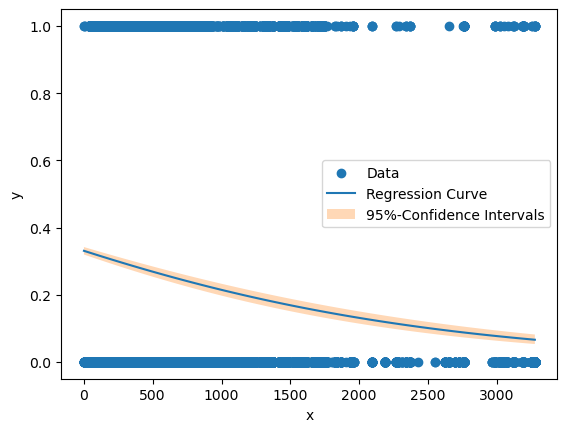

In [180]:
def create_arr():
    
    first_observed_df = first_observed()
    data = clean_and_process()
    locality_df1 = get_locality(data, first_observed_df)
    locality_df = calculate_counts_within_area(locality_df1)
    occurrences_previous = locality_df[['LIDNUM', 'Total_Occurrences_Previous']].set_index('LIDNUM')
    
    # Filter data
    data['LONG'] = pd.to_numeric(data['LONG'], errors='coerce')
    data['LAT'] = pd.to_numeric(data['LAT'], errors='coerce')
    filtered_data = data[
    (data['LONG'] > -25) &
    (data['LONG'] < 40) &
    (data['LAT'] > 35) &
    (data['MN'].isin(['MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19']))
    ]


    filtered_data = filtered_data[['LIDNUM', 'SPECIES_ID', 'MN']].set_index('SPECIES_ID')

    first_df = first_observed_df.set_index('SPECIES_ID')

    merge_first = filtered_data.join(first_df, how='left', rsuffix='oldest').reset_index().set_index('LIDNUM')

    merge_previous = merge_first.join(occurrences_previous, how='left', rsuffix='preceding').reset_index()
    merge_previous['is_first'] = (merge_previous['MN'] == merge_previous['First_Observed_MN']).astype('int')
    print(merge_previous)
    regression_df = merge_previous[['Total_Occurrences_Previous', 'is_first']].copy()
    array = np.array(regression_df)
    X = array[:,0]
    X = sm.add_constant(X)
    y = array[:,1]
    model = sm.Logit(y, X)
    result = model.fit()
    coefficients = result.params
    confidence95 = result.conf_int(alpha=0.05)

    def logit_curve(x, coefficients):
        return 1 / (1 + np.exp(-coefficients[0] - coefficients[1] * x))


    x_values = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    y_values = logit_curve(x_values, coefficients)

    #confidence intervals
    upper_ci = logit_curve(x_values, confidence95[:,0])
    lower_ci = logit_curve(x_values, confidence95[:,1])


    plt.scatter(X[:, 1], y, label='Data')
    plt.plot(x_values, y_values, label='Regression Curve')
    plt.fill_between(x_values, lower_ci, upper_ci, alpha=0.3, label='95%-Confidence Intervals')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    create_arr()


                  GENUS_SPECIES First_Observed_MN  SPECIES_ID LIDNUM
0              Aaptoryctes_ivyi            pre-MN        3648  10168
1        Abderites_meridionalis               MN4         678  28891
2             Abdounodus_hamdii            pre-MN        6680  22640
3        Abelmoschomys_phthanus               MN9        3294  10465
4        Abelmoschomys_simpsoni              MN10        6774  10567
...                         ...               ...         ...    ...
11237  Zygolophodon_shansiensis              MN12       11209  24925
11238   Zygolophodon_turicensis               MN3         343  21188
11239        Zygomaturus_keanei              MN15        9431  27667
11240            gen._dicranius              MN16        7716  20470
11241            indet._indet..            pre-MN        8276  27695

[11242 rows x 4 columns]
Optimization terminated successfully.
         Current function value: 0.304423
         Iterations 7
Coefficients:
[-1.79611807e+00 -6.07302395e-

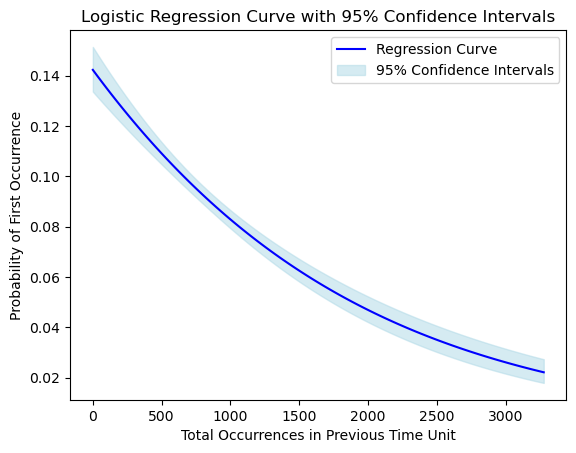

In [173]:
# def european_area(locality_df):
#     # Define the time units
#     time_units = ['MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19']
    
#     # Filter data
#     filtered_data = locality_df[
#         (-25 < locality_df["Longitude"]) & 
#         (locality_df["Longitude"] < 40) & 
#         (locality_df["Latitude"] > 35) & 
#         (locality_df["Time_Unit"].isin(time_units))
#     ]

#     return filtered_data

# def get_regression_arr(filtered_data):
#     # Calculate the total number of occurrences
#     total_occurrences = filtered_data["All_Occurrences"].sum()
    
#     # Create an empty array of size m × 2
#     regression_array = np.zeros((total_occurrences, 2))
    
#     # Initialize index counter
#     index_counter = 0
    
#     # Iterate through filtered data to populate the regression array
#     for _, row in filtered_data.iterrows():
#         # Fill in the first column with Total_Occurrences_Previous
#         occurrences_previous = row["Total_Occurrences_Previous"]
        
#         # Fill in the second column with the count of first occurrences
#         first_occurrences_count = row["First_Occurrences"]
        
#         # Fill the array with the current occurrence x times (x is the count of first occurrences)
#         for _ in range(int(first_occurrences_count)):
#             regression_array[index_counter] = [occurrences_previous, 1]
#             index_counter += 1
        
#         # Fill the array with the remaining occurrences
#         remaining_occurrences = row["All_Occurrences"] - first_occurrences_count
#         for _ in range(int(remaining_occurrences)):
#             regression_array[index_counter] = [occurrences_previous, 0]
#             index_counter += 1

#     return regression_array

# def plot_regression(regression_array, filtered_data):
#     # Perform logistic regression
#     results = perform_lr(regression_array)

#     # Generate x values for prediction
#     min_x = filtered_data['Total_Occurrences_Previous'].min()
#     max_x = filtered_data['Total_Occurrences_Previous'].max()
#     x_values = np.linspace(min_x, max_x, 100)

#     # Predict probabilities using the logistic regression model
#     predicted_probs = results.predict(sm.add_constant(x_values))

#     # Get confidence intervals for the predicted probabilities
#     ci = results.get_prediction(sm.add_constant(x_values)).conf_int()

#     # Plot the regression curve
#     plt.plot(x_values, predicted_probs, color='blue', label='Regression Curve')

#     # Plot the 95% confidence intervals
#     plt.fill_between(x_values, ci[:, 0], ci[:, 1], color='lightblue', alpha=0.5, label='95% Confidence Intervals')

#     # Add labels and legend
#     plt.xlabel('Total Occurrences in Previous Time Unit')
#     plt.ylabel('Probability of First Occurrence')
#     plt.title('Logistic Regression Curve with 95% Confidence Intervals')
#     plt.legend()

#     # Show plot
#     plt.show()

# def perform_lr(arr):
#     X = arr[:, 0]
#     y = arr[:, 1]

#     X = sm.add_constant(X)
#     model = sm.Logit(y, X)
#     results = model.fit()
#     print("Coefficients:")
#     print(results.params)
#     print("\nP-values:")
#     print(results.pvalues)
#     return results

# if __name__ == '__main__':
#     # Assume you have already obtained the locality DataFrame
#     data = clean_and_process()
#     first_observed_df = first_observed()
#     locality_df_total = get_locality(data, first_observed_df)
#     locality_df = calculate_counts_within_area(locality_df_total)
#     filtered_data = european_area(locality_df)
#     regression_arr = get_regression_arr(filtered_data)
#     plot_regression(regression_arr, filtered_data)


### Idea of solution
1. col1: m is the sum of all localities' total occurrences, col2: total-first times 0(non first), first times 1

### Discussion
1. The first time and total number should be the locality's?

## 8 Proportion for each locality in the focal area using regression

In [153]:
def calculate_expected_proportion(filtered_data, results):
    # Add constant to the data
    X = sm.add_constant(filtered_data[['Total_Occurrences_Previous']])  # Include all relevant features

    # Predict probabilities using the logistic regression model
    predicted_probs = results.predict(X)

    # Calculate the expected proportion of first occurrences
    expected_proportion = predicted_probs * filtered_data['All_Occurrences']

    return expected_proportion

if __name__ == '__main__':
    data = clean_and_process()
    first_observed_df = first_observed()
    locality_df_total = get_locality(data, first_observed_df)
    locality_df = calculate_counts_within_area(locality_df_total)
    filtered_data = european_area(locality_df)
    arr = get_regression_arr(filtered_data)
    results = perform_lr(arr)
    proportion = calculate_expected_proportion(filtered_data, results)
    print(proportion)

                  GENUS_SPECIES First_Observed_MN  SPECIES_ID LIDNUM
0              Aaptoryctes_ivyi            pre-MN        3648  10168
1        Abderites_meridionalis               MN4         678  28891
2             Abdounodus_hamdii            pre-MN        6680  22640
3        Abelmoschomys_phthanus               MN9        3294  10465
4        Abelmoschomys_simpsoni              MN10        6774  10567
...                         ...               ...         ...    ...
11237  Zygolophodon_shansiensis              MN12       11209  24925
11238   Zygolophodon_turicensis               MN3         343  21188
11239        Zygomaturus_keanei              MN15        9431  27667
11240            gen._dicranius              MN16        7716  20470
11241            indet._indet..            pre-MN        8276  27695

[11242 rows x 4 columns]
Optimization terminated successfully.
         Current function value: 0.304423
         Iterations 7
0        0.022178
5        0.468891
10      

### Idea of solution
1. add constant to data, predict()probabilities

## 9 Probability of first occurrence more than the prediction

In [154]:
def more_first(filtered_data, expected_proportion):
    # Total number of occurrences in the focal area
    total_occurrences_area = filtered_data['Total_Occurrences_Area']
    
    # Number of observed first occurrences
    observed_first_occurrences = filtered_data['Total_First_Occurrences_Area']
    
    # Calculate the probability of observing as many or more first occurrences
    probability = 1 - binom.cdf(observed_first_occurrences - 1, total_occurrences_area, expected_proportion)
    # print(probability)
    return probability


if __name__ == '__main__':
    data = clean_and_process()
    first_observed_df = first_observed()
    locality_df_total = get_locality(data, first_observed_df)
    locality_df = calculate_counts_within_area(locality_df_total)
    filtered_data = european_area(locality_df)
    arr = get_regression_arr(filtered_data)
    results = perform_lr(arr)
    expected_proportion = calculate_expected_proportion(filtered_data, results)
    more_first(filtered_data, expected_proportion)
    

                  GENUS_SPECIES First_Observed_MN  SPECIES_ID LIDNUM
0              Aaptoryctes_ivyi            pre-MN        3648  10168
1        Abderites_meridionalis               MN4         678  28891
2             Abdounodus_hamdii            pre-MN        6680  22640
3        Abelmoschomys_phthanus               MN9        3294  10465
4        Abelmoschomys_simpsoni              MN10        6774  10567
...                         ...               ...         ...    ...
11237  Zygolophodon_shansiensis              MN12       11209  24925
11238   Zygolophodon_turicensis               MN3         343  21188
11239        Zygomaturus_keanei              MN15        9431  27667
11240            gen._dicranius              MN16        7716  20470
11241            indet._indet..            pre-MN        8276  27695

[11242 rows x 4 columns]
Optimization terminated successfully.
         Current function value: 0.304423
         Iterations 7


# 10 Describe overall patterns
1. Plot locality on map and indicate significance level with sliding color scheme
2. Highlight p_level that less than 0.05
3. describe overall level

                  GENUS_SPECIES First_Observed_MN  SPECIES_ID LIDNUM
0              Aaptoryctes_ivyi            pre-MN        3648  10168
1        Abderites_meridionalis               MN4         678  28891
2             Abdounodus_hamdii            pre-MN        6680  22640
3        Abelmoschomys_phthanus               MN9        3294  10465
4        Abelmoschomys_simpsoni              MN10        6774  10567
...                         ...               ...         ...    ...
11237  Zygolophodon_shansiensis              MN12       11209  24925
11238   Zygolophodon_turicensis               MN3         343  21188
11239        Zygomaturus_keanei              MN15        9431  27667
11240            gen._dicranius              MN16        7716  20470
11241            indet._indet..            pre-MN        8276  27695

[11242 rows x 4 columns]
Optimization terminated successfully.
         Current function value: 0.304423
         Iterations 7
[0.00000000e+00 7.20115498e-47]


/var/folders/_r/cgkzrs6969g_s1zjnk1m6rl00000gn/T/ipykernel_55137/2905390875.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


ValueError: 'c' argument has 2 elements, which is inconsistent with 'x' and 'y' with size 3178.

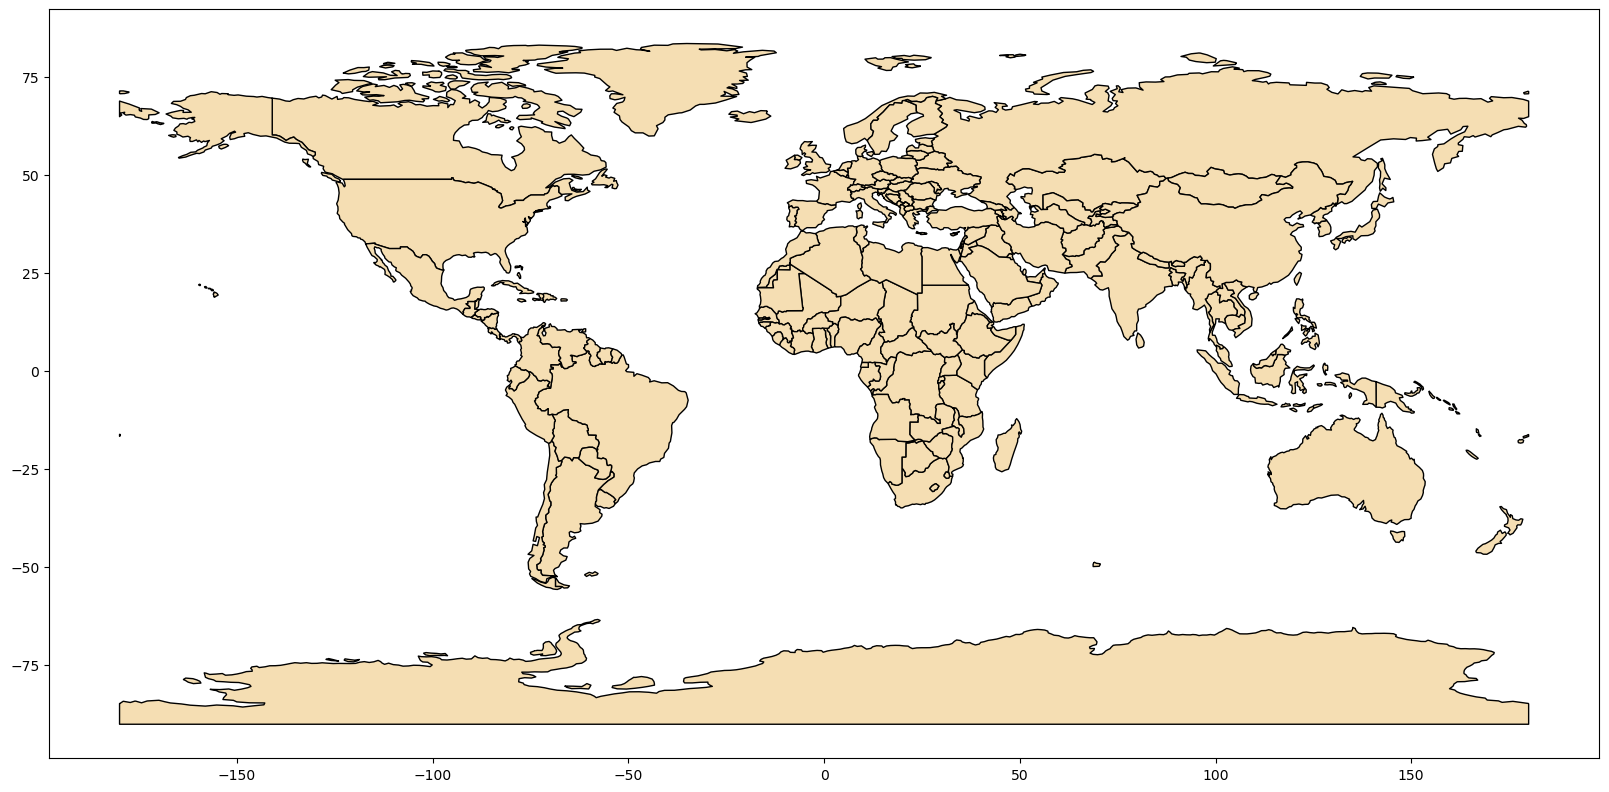

In [171]:
# Step 1: Calculate p-values from logistic regression results
def calculate_significance_levels(results):
    # Extract p-values from the logistic regression results
    p_values = results.pvalues
    print(p_values)
    return p_values

def plot_localities_on_map(filtered_data, p_values):
    # Plot the world map
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    fig, ax = plt.subplots(figsize=(20, 10))
    world.plot(ax=ax, color='wheat', edgecolor='black')

    # Calculate marker size relative to the number of occurrences
    marker_size = filtered_data['All_Occurrences'] * 1  # Adjust multiplier as needed for better visualization

    # Map p-values to colors using a colormap
    norm = plt.Normalize(vmin=min(p_values), vmax=max(p_values))
    cmap = cm.RdYlBu  # You can choose any colormap here
    colors = cmap(norm(p_values))

    # Plot localities with significance level indicated by color
    ax.scatter(filtered_data['Longitude'], filtered_data['Latitude'], s=marker_size, alpha=0.5, c=colors)

    # Set axis labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Localities on a Map with Significance Level")

    # Show plot
    plt.show()

# Step 3: Highlight Significant Localities
def highlight_significant_localities(filtered_data, p_values):
    # Plot the localities on a map
    plot_localities_on_map(filtered_data, p_values)

if __name__ == '__main__':
    # Load the filtered data and perform logistic regression
    data = clean_and_process()
    first_observed_df = first_observed()
    locality_df_total = get_locality(data, first_observed_df)
    locality_df = calculate_counts_within_area(locality_df_total)
    filtered_data = european_area(locality_df)
    arr = get_regression_arr(filtered_data)
    results = perform_lr(arr)

    # Calculate p-values
    p_values = calculate_significance_levels(results)

    # Highlight significant localities on the map
    highlight_significant_localities(filtered_data, p_values)